# Optimizing Traffic Flow Using Reinforcement Learning - Part 1
### Task 2, 3, 4

Full assignment: https://gist.github.com/RafalKucharskiPK/c3bc960f047829569808ccbcffc3b8ce

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Introduction

This notebook aims to extend our analytical insights into optimizing traffic flow by employing **Reinforcement Learning (RL)** techniques. We will focus on:

* Formulating our traffic optimization problem as an RL problem, using states, actions, policies, and rewards.
* Implementing our formulation using RL framwork.
* Comparing the RL-based solutions with the analytical results to validate the efficacy of our RL approach.

Our ultimate objective is to demonstrate how RL can be effectively used to solve complex, real-world problems like traffic flow optimization.

At this step, since we are focused on finding a model that can effectively converge to the system optimum and user equilibirum, we will have a centralized approach and we will assume that **the entire traffic flow is managed by one central agent**. However, we do not only aim our central agent to find a policy that leads to an eventual result under the parameterization, **we aim to enable this agent to have an understanding about what kind of decision making is needed for balancing the traffic flow at every step of the episode**.

# Remodeling the System as a RL Problem

### Environment

I have designed an environment that is simple yet able to capture all the requirements imposed by the problem definiton. The overall structure of the enironment for both SO and UE are very similar, they differ in their reward functions. They are both designed to accept binary actions, for adding a single car on Route A or Route B. Initially, both roads are empty. The environments finalize the episode when $q_a+q_b=Q$. 

### State Space

The discrete state space is made of tuples `(q_a, q_b)` representing the current number of vehicles on each route. It is a discrete state space as this aligns with the discrete nature of vehicle counts. Transitions between states are defined only in terms of addition of a single car on one of the routes, therefore to keep everything more realistic, I made it impossible to decrease the number of cars in a route once it is added. Keeping the state space discrete makes the problem tractable and well-suited for a table look-up policy.

### Action Space

The action space consists of only two actions:
1. Add one vehicle to route `A` (increase q_a by one)
2. Add one vehicle to route `B` (increase q_b by one)

Incremental actions provide a fine-grained control over traffic distribution, which is especially useful for achieving SO and UE.

### Agent

The agent uses a deterministic table look-up policy and employs Q-Learning algorithm to learn the best actions to take in various states. Therefore we are more interested in the value of taking an action a in a state s, rather than assigning values for each state.

Given the discrete and finite nature of the state and action spaces, a table look-up policy offers an efficient way to store and retrieve the optimal policy. Q-Learning, being an off-policy algorithm, allows the agent to learn optimal policies efficiently.

The deterministic look-up policy might create problems in exploration/exploitation, therefore I have also added an epsilon term to occasionally make random decisions, so that a good portion of the state space is explored. The learning process involves epsilon decay, so that after we do the necessary exploration, we can exploit the best states and tune our quality function.

### Reward Function

Reward function is the part that enables an agent to learn how to handle traffic flow efficiently in **every step in an episode**, rather than reaching to a SO or UE after a set of random actions. 

For instance, if we know that we have system optimality when $q_a = x$ and $q_b = y$, the agent should not keep adding cars to one of the routes and then proceed with the other one. This will create high congestion in one of the routes while other route is completely empty. Rather, **the agent should be mindful and add cars in such a way that in every step of the episode the congestions in both of the routes are ideal**. However, it should be noted that achieving this to the full extent is not expected, since the main objective is to find the SO/UE in the end of the episode and the reward functions are designed accordingly.

Also, in order to utilize fully every training episode and handle credit assignment problem, one needs to make sure the rewards are dense enough. 

To achieve this, I built reward functions that are essentially the given formulas but with few tricks.

For the **SO** task, the reward function is defined as follows:

$
k1 = q_a + \frac{Q - (q_a + q_b)}{2}\newline
k2 = q_b + \frac{Q - (q_a + q_b)}{2}\newline
\text{If this is an intermediate state, } reward = -\frac{t_a(k1) \cdot k1 + t_b(k2) \cdot k2}{2 \cdot Q} \newline
\text{If this is a terminal state, } reward = -(t_a(k1) \cdot k1 + t_b(k2) \cdot k2) \newline
$

For the **UE** task, the reward function is defined as follows:
$
k1 = q_a + \frac{Q - (q_a + q_b)}{2}\newline
k2 = q_b + \frac{Q - (q_a + q_b)}{2}\newline
\text{If this is an intermediate state, } reward = -\frac{abs(t_a(k1) - t_b(k2))}{2 \cdot Q} \newline
\text{If this is a terminal state, } reward = -abs(t_a(k1) - t_b(k2)) \newline
$

This approach ensures that the agent looks ahead and makes decisions that are beneficial in the long run. It can be seen that ***the quality of the final state is much more pronounced***, this is for assuring the convergence to the solution of our problem.

### Functions and Parameters

In [2]:
# t and cost functions

travel_time = lambda q_x, t0_x, Q_x: t0_x * (1 + pow(q_x/Q_x, 2))

def total_cost(q_a, t0_a, Q_a, q_b, t0_b, Q_b, Q):
    if (q_a < 0) or (q_b < 0):
        raise ValueError("Invalid configuration: Numbers of vehicles cannot be negative.")
    else:
        return (travel_time(q_a, t0_a, Q_a) * q_a) + (travel_time(q_b, t0_b, Q_b) * q_b)

In [3]:
# Parameterization

Q = 1000
t0_a = 5 / 60
t0_b = 15 / 60
Q_a = 500
Q_b = 800

In [4]:
state_space_size=1001 # [0,1000] for both q_a and q_b, constrained
action_space_size=2 # Add a car either on Route A or Route B

# System Optimality (SO)

At the previous step of this assignment, we came to the conclusion that the values $q_a = 597$ and $q_b = 403$ are ideal for system optimality. Let's see if our RL system can yield the same results.

### Environment

In [5]:
class TrafficEnvironment_SO:
    
    def __init__(self, Q, t0_a, t0_b, Q_a, Q_b):
        self.Q = Q
        self.t0_a = t0_a
        self.t0_b = t0_b
        self.Q_a = Q_a
        self.Q_b = Q_b
        
        self.reset()
        
    def reset(self):
        self.q_a, self.q_b = 0, 0
        self.done = False
        return (self.q_a, self.q_b)
        
    def step(self, action):
        if self.done:
            print("Episode already done!")
            return
        
        if action == 0:  # Increment q_a
            self.q_a += 1
        elif action == 1:  # Increment q_b
            self.q_b += 1
            
        reward = self.calculate_reward(self.q_a, self.q_b)
        
        if self.q_a + self.q_b >= self.Q:
            self.done = True
            
        return (self.q_a, self.q_b), reward, self.done
    
    def calculate_reward(self, q_a, q_b):
        k1 = q_a + (self.Q - (q_a + q_b)) / 2
        k2 = q_b + (self.Q - (q_a + q_b)) / 2
        reward = -1 * total_cost(k1, self.t0_a, self.Q_a, k2, self.t0_b, self.Q_b, self.Q)
        return reward if (q_a + q_b) == self.Q else reward/(2 * self.Q)

### Agent

In [6]:
class TrafficControlAgent:
    
    def __init__(self, state_space_size, action_space_size, alpha=0.25, gamma=0.8, epsilon=1.0):
        self.epsilon = epsilon  # exploration rate
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.action_space_size = action_space_size
        self.q_table = np.zeros((state_space_size, state_space_size, self.action_space_size))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon: 
            return np.random.choice(self.action_space_size)
        else: 
            return np.argmax(self.q_table[state[0]][state[1]])

    def update_q_value(self, state, action, reward, next_state):
        best_future_q = np.max(self.q_table[next_state[0]][next_state[1]])
        prev_q = self.q_table[state[0]][state[1]][action]
        new_q = self.alpha * (reward + (self.gamma * best_future_q) - prev_q)
        self.q_table[state[0]][state[1]][action] = new_q

    def decay_epsilon(self, decay_rate):
        self.epsilon *= decay_rate

### Learning

In [7]:
# Initialize environment & agent
env = TrafficEnvironment_SO(Q, t0_a, t0_b, Q_a, Q_b)
agent = TrafficControlAgent(state_space_size, action_space_size)

In [8]:
# Simulation parameters
num_episodes = 1000
decay_rate = 0.99  # Decay rate for epsilon

# Track of rewards & final states for analysis
rewards = list()
final_states = list()

# Training
for episode in range(num_episodes):
    
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        # Update Q-table based on reward and next state
        agent.update_q_value(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
    
    # Epsilon scheduling
    agent.decay_epsilon(decay_rate)
    
    # Reward & state for this episode
    rewards.append(total_reward)
    final_states.append(state)
    
    if ((episode+1) % (num_episodes//10) == 0) or (episode == 0):
        print("\r------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [TOTAL REWARD] %.3f [FINAL STATE] q_a: %d, q_b: %d [EPSILON] %.6f" \
    % (episode+1, reward, total_reward, state[0], state[1], agent.epsilon))

------------ EPISODE #1 ------------
 [FINAL REWARD] -254.620 [TOTAL REWARD] -383.155 [FINAL STATE] q_a: 513, q_b: 487 [EPSILON] 0.990000
------------ EPISODE #100 ------------
 [FINAL REWARD] -248.817 [TOTAL REWARD] -374.922 [FINAL STATE] q_a: 556, q_b: 444 [EPSILON] 0.366032
------------ EPISODE #200 ------------
 [FINAL REWARD] -248.762 [TOTAL REWARD] -373.519 [FINAL STATE] q_a: 638, q_b: 362 [EPSILON] 0.133980
------------ EPISODE #300 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -371.189 [FINAL STATE] q_a: 597, q_b: 403 [EPSILON] 0.049041
------------ EPISODE #400 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -371.209 [FINAL STATE] q_a: 597, q_b: 403 [EPSILON] 0.017951
------------ EPISODE #500 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -371.147 [FINAL STATE] q_a: 597, q_b: 403 [EPSILON] 0.006570
------------ EPISODE #600 ------------
 [FINAL REWARD] -246.992 [TOTAL REWARD] -371.032 [FINAL STATE] q_a: 597, q_b: 403 [EPSILON] 0.002405
------------ EPISODE #

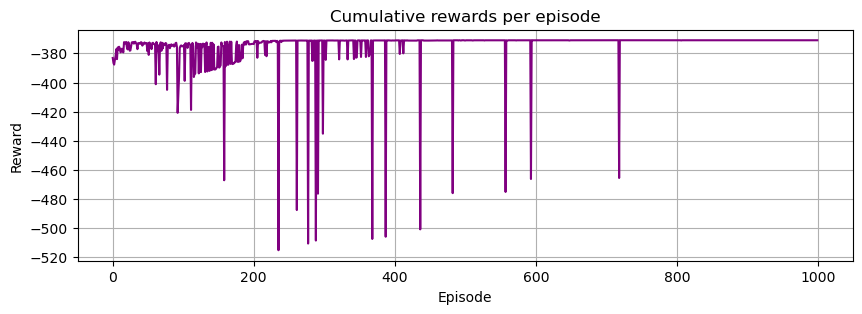

In [9]:
plt.figure(figsize=(10,3))

plt.plot(rewards, color="purple")

plt.title("Cumulative rewards per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.grid(True)
plt.show()

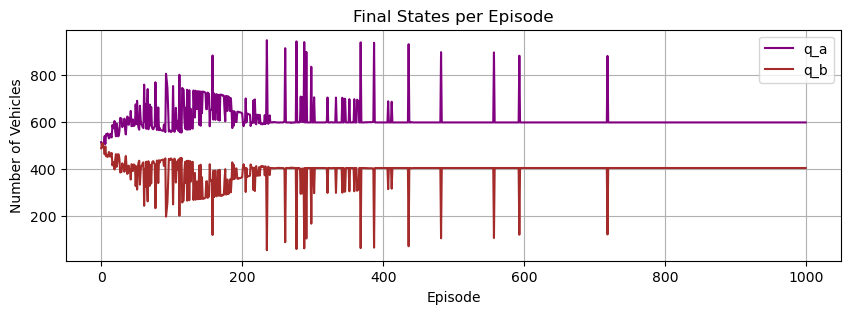

In [10]:
plt.figure(figsize=(10,3))

plt.plot(range(len(final_states)), [x[0] for x in final_states], label="q_a", color="purple")
plt.plot(range(len(final_states)), [x[1] for x in final_states], label="q_b", color="brown")

plt.title("Final States per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Vehicles")

plt.grid(True)
plt.legend()
plt.show()

### Testing the agent

In [11]:
state = env.reset()
done = False
total_reward = 0

states = list()
rewards = list()

while not done:
    action = np.argmax(agent.q_table[state[0]][state[1]])
    next_state, reward, done = env.step(action)
    state = next_state
    total_reward += reward
    states.append(state)
    rewards.append(reward)
    
print("Finished episode at\n State q_a: %d, q_b: %d\n Cumulative reward: %.3f" % (state[0], state[1], total_reward))

Finished episode at
 State q_a: 597, q_b: 403
 Cumulative reward: -371.008


***The agent successfully found the system optimal solution for this problem!***

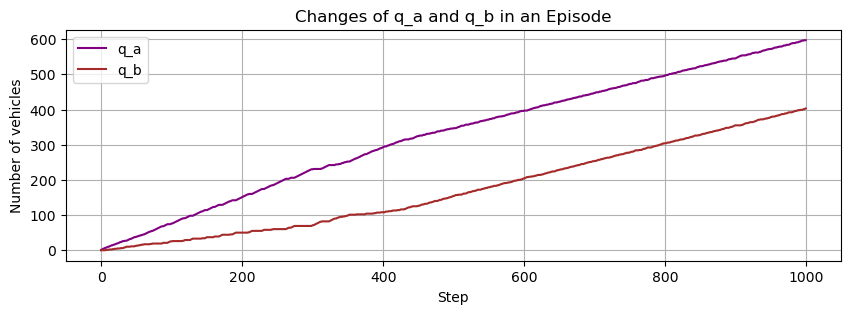

In [12]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [x[0] for x in states], label="q_a", color="purple")
plt.plot(range(len(states)), [x[1] for x in states], label="q_b", color="brown")

plt.title("Changes of q_a and q_b in an Episode")
plt.xlabel("Step")
plt.ylabel("Number of vehicles")

plt.grid(True)
plt.legend()
plt.show()

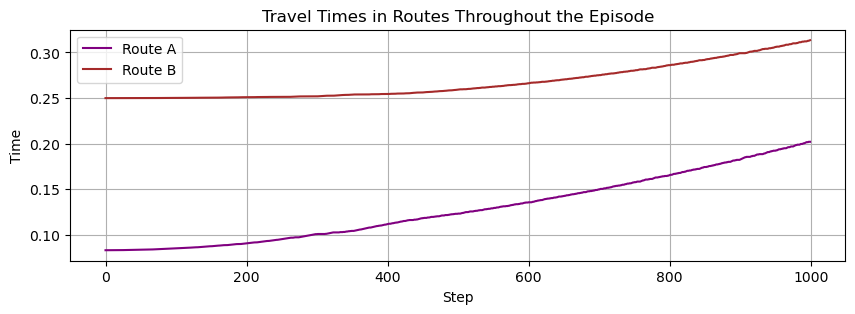

In [13]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [travel_time(x[0], t0_a, Q_a) for x in states], label="Route A", color="purple")
plt.plot(range(len(states)), [travel_time(x[1], t0_b, Q_b) for x in states], label="Route B", color="brown")

plt.title("Travel Times in Routes Throughout the Episode")
plt.xlabel("Step")
plt.ylabel("Time")

plt.grid(True)
plt.legend()
plt.show()

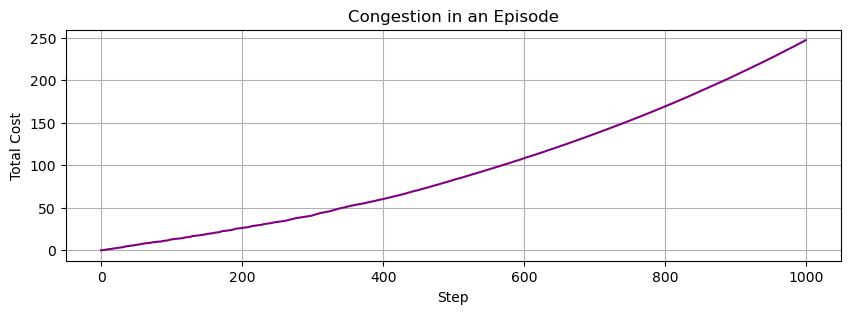

In [14]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [total_cost(x[0], t0_a, Q_a, x[1], t0_b, Q_b, Q) for x in states], color="purple")

plt.title("Congestion in an Episode")
plt.xlabel("Step")
plt.ylabel("Total Cost")

plt.grid(True)
plt.show()

# User Equilibrium

At the previous step of this assignment, we came to the conclusion that the values $q_a = 755$ and $q_b = 245$ are ideal for the User Equilibrium. Let's see if our RL system can yield the same results.

### Environment

In [15]:
class TrafficEnvironment_UE:
    def __init__(self, Q, t0_a, t0_b, Q_a, Q_b):
        self.Q = Q
        self.t0_a = t0_a
        self.t0_b = t0_b
        self.Q_a = Q_a
        self.Q_b = Q_b
        self.reset()
        
    def reset(self):
        self.q_a = 0
        self.q_b = 0
        self.done = False
        return (self.q_a, self.q_b)
        
    def step(self, action):
        if self.done:
            print("Episode already done!")
            return
        
        if action == 0:  # Increment q_a
            self.q_a += 1
        elif action == 1:  # Increment q_b
            self.q_b += 1
            
        reward = self.calculate_reward(self.q_a, self.q_b)
        
        if self.q_a + self.q_b >= self.Q:
            self.done = True
            
        return (self.q_a, self.q_b), reward, self.done
    
    def calculate_reward(self, q_a, q_b):
        k1 = q_a + (self.Q - (q_a + q_b)) / 2
        k2 = q_b + (self.Q - (q_a + q_b)) / 2
        reward = -abs(travel_time(k1, self.t0_a, self.Q_a) - travel_time(k2, self.t0_b, self.Q_b))
        if q_a + q_b == self.Q:
            return reward
        else:
            return reward/(2 * self.Q)

### Agent

**We will use the same agent class for this task.**

### Learning

In [16]:
# Initialize environment & agent
env = TrafficEnvironment_UE(Q, t0_a, t0_b, Q_a, Q_b)
agent = TrafficControlAgent(state_space_size, action_space_size)

In [17]:
# Simulation parameters
num_episodes = 1000
decay_rate = 0.99  # Decay rate for epsilon

# Track of rewards & final states for analysis
rewards = list()
final_states = list()

# Training
for episode in range(num_episodes):
    
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        # Update Q-table based on reward and next state
        agent.update_q_value(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
    
    # Epsilon scheduling
    agent.decay_epsilon(decay_rate)
    
    # Reward & state for this episode
    rewards.append(total_reward)
    final_states.append(state)
    
    if ((episode+1) % (num_episodes//10) == 0) or (episode == 0):
        print("\r------------ EPISODE #%d ------------\n [FINAL REWARD] %.3f [TOTAL REWARD] %.3f [FINAL STATE] q_a: %d, q_b: %d [EPSILON] %.6f" \
    % (episode+1, reward, total_reward, state[0], state[1], agent.epsilon))

------------ EPISODE #1 ------------
 [FINAL REWARD] -0.188 [TOTAL REWARD] -0.282 [FINAL STATE] q_a: 491, q_b: 509 [EPSILON] 0.990000
------------ EPISODE #100 ------------
 [FINAL REWARD] -0.040 [TOTAL REWARD] -0.079 [FINAL STATE] q_a: 813, q_b: 187 [EPSILON] 0.366032
------------ EPISODE #200 ------------
 [FINAL REWARD] -0.010 [TOTAL REWARD] -0.062 [FINAL STATE] q_a: 741, q_b: 259 [EPSILON] 0.133980
------------ EPISODE #300 ------------
 [FINAL REWARD] -0.037 [TOTAL REWARD] -0.090 [FINAL STATE] q_a: 702, q_b: 298 [EPSILON] 0.049041
------------ EPISODE #400 ------------
 [FINAL REWARD] -0.060 [TOTAL REWARD] -0.108 [FINAL STATE] q_a: 670, q_b: 330 [EPSILON] 0.017951
------------ EPISODE #500 ------------
 [FINAL REWARD] -0.013 [TOTAL REWARD] -0.054 [FINAL STATE] q_a: 737, q_b: 263 [EPSILON] 0.006570
------------ EPISODE #600 ------------
 [FINAL REWARD] -0.000 [TOTAL REWARD] -0.039 [FINAL STATE] q_a: 755, q_b: 245 [EPSILON] 0.002405
------------ EPISODE #700 ------------
 [FINAL REW

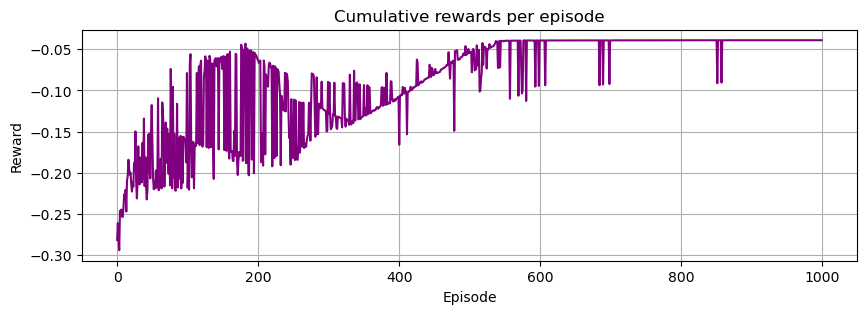

In [18]:
plt.figure(figsize=(10,3))

plt.plot(rewards, color="purple")

plt.title("Cumulative rewards per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.grid(True)
plt.show()

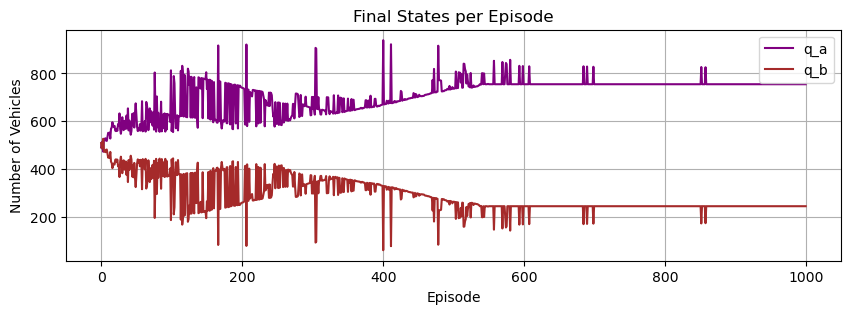

In [19]:
plt.figure(figsize=(10,3))

plt.plot(range(len(final_states)), [x[0] for x in final_states], label="q_a", color="purple")
plt.plot(range(len(final_states)), [x[1] for x in final_states], label="q_b", color="brown")

plt.title("Final States per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Vehicles")

plt.grid(True)
plt.legend()
plt.show()

### Testing the agent

In [20]:
state = env.reset()
done = False
total_reward = 0

states = list()
rewards = list()

while not done:
    action = np.argmax(agent.q_table[state[0]][state[1]])
    next_state, reward, done = env.step(action)
    state = next_state
    total_reward += reward
    states.append(state)
    rewards.append(reward)
    
print("Finished episode at\n State q_a: %d, q_b: %d\n Cumulative reward: %.3f" % (state[0], state[1], total_reward))

Finished episode at
 State q_a: 755, q_b: 245
 Cumulative reward: -0.039


***The agent successfully found the solution that provides the user equilibrium for this problem!***

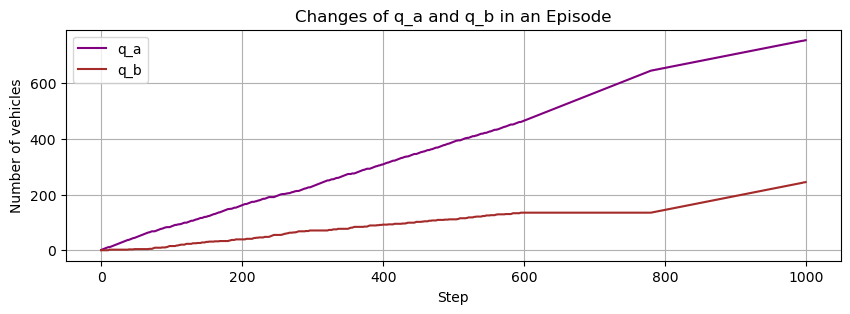

In [21]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [x[0] for x in states], label="q_a", color="purple")
plt.plot(range(len(states)), [x[1] for x in states], label="q_b", color="brown")

plt.title("Changes of q_a and q_b in an Episode")
plt.xlabel("Step")
plt.ylabel("Number of vehicles")

plt.grid(True)
plt.legend()
plt.show()

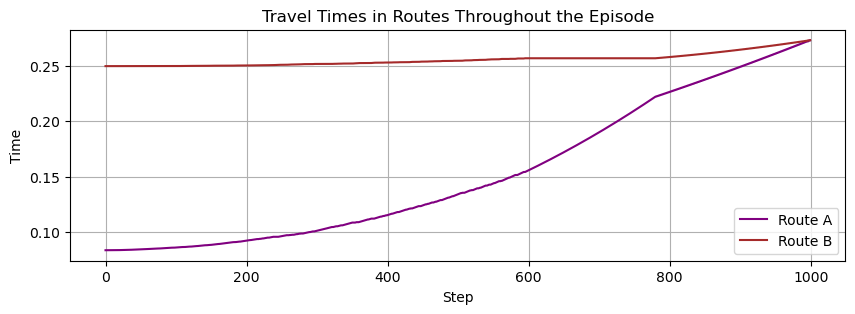

In [22]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [travel_time(x[0], t0_a, Q_a) for x in states], label="Route A", color="purple")
plt.plot(range(len(states)), [travel_time(x[1], t0_b, Q_b) for x in states], label="Route B", color="brown")

plt.title("Travel Times in Routes Throughout the Episode")
plt.xlabel("Step")
plt.ylabel("Time")

plt.grid(True)
plt.legend()
plt.show()

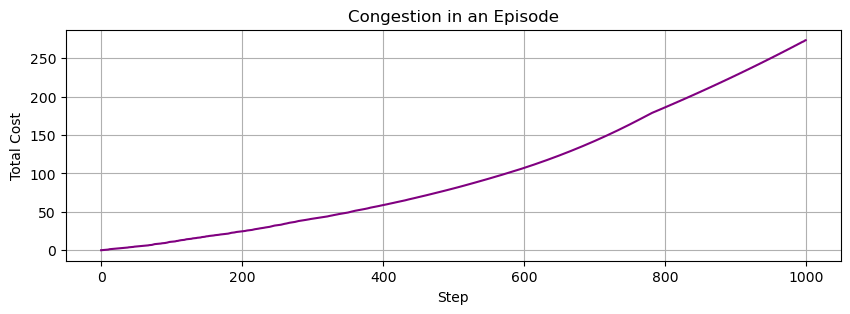

In [23]:
plt.figure(figsize=(10,3))

plt.plot(range(len(states)), [total_cost(x[0], t0_a, Q_a, x[1], t0_b, Q_b, Q) for x in states], color="purple")

plt.title("Congestion in an Episode")
plt.xlabel("Step")
plt.ylabel("Total Cost")

plt.grid(True)
plt.show()

# Conclusion

We have successfully modeled this traffic optimization problem using Reinforcement Learning. Our agents are capable of not just finding the System Optimum (SO) and User Equilibrium (UE) but also do so while considering incremental car distribution throughout every episode.

### Takeaways

1. **Discrete State Space**: Made the problem more manageable and ideal for a look-up table policy.
2. **Reward Function**: Designed to consider both the final goal and the intermediate steps, leading to a more holistic approach to traffic optimization.
3. **Efficient Learning**: Utilizing Q-Learning, our agents learned optimal policies efficiently.
